# Imports

In [11]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler

# Loading the Data

In [12]:
# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Quick overview of dataset
train_dfs = df.copy()

# We will only use the Closing Column
train_dfs = train_dfs['Close']

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,2311.149902,2294.409912,2294.409912,2308.419922,1931380000,2308.419922
2010-01-05,2313.729980,2295.620117,2307.270020,2308.709961,2367860000,2308.709961
2010-01-06,2314.070068,2295.679932,2307.709961,2301.090088,2253340000,2301.090088
2010-01-07,2301.300049,2285.219971,2298.090088,2300.050049,2270050000,2300.050049
2010-01-08,2317.600098,2290.610107,2292.239990,2317.169922,2145390000,2317.169922
...,...,...,...,...,...,...
2020-06-22,10059.610352,9916.599609,9945.490234,10056.480469,4468000000,10056.480469
2020-06-23,10221.849609,10112.440430,10130.830078,10131.370117,5712450000,10131.370117
2020-06-24,10137.500000,9842.219727,10092.919922,9909.169922,5549440000,9909.169922


# Feature Engineering

In [14]:
# Indexing Batches
train_df = train_dfs.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index
date_index_df = pd.DataFrame(date_index)

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Day'] = d.strftime("%d") 
train_df['Month'] = d.strftime("%m") 
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df.reset_index(level=0, inplace=True)
train_df.tail(5)

,Date,High,Low,Open,Close,Volume,Adj Close,Day,Month,Year,50days_batch,100days_batch,200days_batch
2634,2020-06-22,10059.610352,9916.599609,9945.490234,10056.480469,4468000000,10056.480469,22,06,2020,52,26,13
2635,2020-06-23,10221.849609,10112.440430,10130.830078,10131.370117,5712450000,10131.370117,23,06,2020,52,26,13
2636,2020-06-24,10137.500000,9842.219727,10092.919922,9909.169922,5549440000,9909.169922,24,06,2020,52,26,13
2637,2020-06-25,10023.280273,9810.469727,9899.360352,10017.000000,4709620000,10017.000000,25,06,2020,52,26,13
2638,2020-06-26,10000.669922,9749.070312,9995.120117,9757.219727,7279230000,9757.219727,26,06,2020,52,26,13


In [15]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    #--- Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # Exponential Moving Averages
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()
    
    #replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    return df

In [16]:
# List of considered Features
FEATURES = [
            'Close',
#             'Volume',
            'Date',
#             'Day',
#             'Month',
#             'Year',
#             'MA200',
#             'MA100',            
#             'MA50',
#             'MA26',
#             'MA12',
            'EMA20',
#             'EMA100',
#             'EMA200'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features
data = createFeatures(train_df)

# The date from which on the date is displayed
use_start = "2010-11-01" 
use_start_date = pd.to_datetime(use_start)

# Shift the timeframe by 10 month
data = data[data['Date'] > use_start_date].copy()

# Filter the data to the list of FEATURES
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close'] 

data_filtered_ext.tail()

FEATURE LIST
['Close', 'Date', 'EMA20', 'EMA100', 'EMA200']


,Close,Date,EMA20,EMA100,EMA200,Prediction
2634,10056.480469,2020-06-22,9696.619623,8977.162970,8693.128643,10056.480469
2635,10131.370117,2020-06-23,9738.024432,9000.018557,8707.439503,10131.370117
2636,9909.169922,2020-06-24,9754.324002,9018.021555,8719.397020,9909.169922
2637,10017.000000,2020-06-25,9779.340764,9037.803306,8732.308492,10017.000000
2638,9757.219727,2020-06-26,9777.233998,9052.049176,8742.506614,9757.219727


6


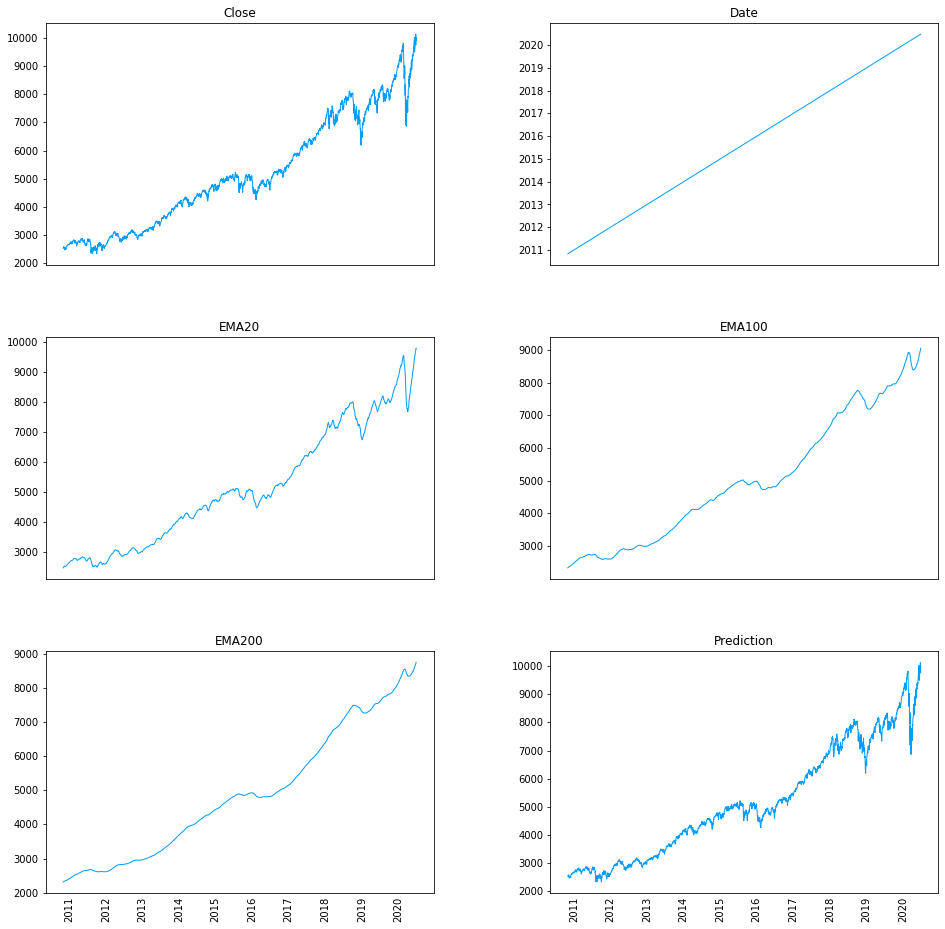

In [17]:
# remove Date column before training
dfs = data_filtered_ext.copy()
del dfs[('Date')]
del dfs[('Prediction')]

# Register matplotlib converters
register_matplotlib_converters()
print(data_filtered_ext.shape[1])

# Define plot parameters 
ncols = 2
nrows = int(round(data_filtered_ext.shape[1] / ncols, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 16))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot each column
x = data_filtered_ext['Date']
f = 0
for i in range(nrows):
    for j in range(ncols):
            #ax[i, j].xaxis.set_major_locator(mdates.YearLocator())
            if f < data_filtered_ext.shape[1]:
                assetname = data_filtered_ext.columns[f]
                y = data_filtered_ext[assetname]
                f += 1
                ax[i, j].plot(x, y, color='#039dfc', label=stockname, linewidth=1.0)
                ax[i, j].set_title(assetname)
                ax[i, j].tick_params(axis="x", rotation=90, labelsize=10, length=0)   

# Data Transformation and Scaling

In [18]:
# Calculate the number of rows in the data
nrows = dfs.shape[0]
np_data_unscaled = np.reshape(np.array(dfs), (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2429, 4)


# Define the Parameter Grid

In [19]:
# Define Sequence Length
sequence_length = 40

# Split the training data into x_train and y_train data sets
# Get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8) #2616
print(train_data_len)

# Create the training data
train_data = np_data[0:train_data_len, :]
x_train, y_train = [], []

# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, sequence_length time steps per sample, and z features
for i in range(sequence_length, train_data_len):
    x_train.append(train_data[i-sequence_length:i,:]) #contains n values 0-sequence_length * columns
    y_train.append(train_data[i, 0]) #contains the prediction values for validation

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Create the test data
test_data = np_data[train_data_len - sequence_length:, :]

# Split the test data into x_test and y_test
x_test, y_test = [], []
test_data_len = test_data.shape[0]
print(test_data_len)
for i in range(sequence_length, test_data_len):
    x_test.append(test_data[i-sequence_length:i,:]) #contains n values 0-sequence_length * columns
    y_test.append(test_data[i, 0]) #contains the prediction values for validation
# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Convert the x_train and y_train to numpy arrays
x_test = np.array(x_test); y_test = np.array(y_test)

# Print Shapes
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

1944
525
(1904, 40, 4) (1904,)
(485, 40, 4) (485,)


# Model Training and Hyperparameter Tuning

In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n Neurons 
# inputshape = t Timestamps x f Features
n_neurons = x_train.shape[1] * x_train.shape[2]
print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(n_neurons))
model.add(Dense(1, activation='relu'))

# Compile the model optimizer  
# works: adam, patience=10
# The default solver ‘adam’ works pretty well on relatively large 
# datasets (with thousands of training samples or more) in terms of both training time and validation score.
# mean_absolute_percentage_error, mean_squared_error
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#learning_rate = 'adaptive'
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop])

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(6, 6), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

timesteps: 40, features:4
Epoch 1/50
1904/1904 [==============================] - 14s 8ms/step - loss: 0.1067
Epoch 2/50
1904/1904 [==============================] - 14s 7ms/step - loss: 0.1038
Epoch 3/50
1904/1904 [==============================] - 14s 8ms/step - loss: 0.1038
Epoch 4/50
1904/1904 [==============================] - 16s 8ms/step - loss: 0.1039
Epoch 5/50
1904/1904 [==============================] - 15s 8ms/step - loss: 0.1038
Epoch 6/50
1904/1904 [==============================] - 16s 8ms/step - loss: 0.1037
Epoch 7/50
1904/1904 [==============================] - 15s 8ms/step - loss: 0.1036
Epoch 8/50
1904/1904 [==============================] - 16s 8ms/step - loss: 0.1037
Epoch 9/50
1904/1904 [==============================] - 18s 9ms/step - loss: 0.1036
Epoch 10/50
1904/1904 [==============================] - 18s 10ms/step - loss: 0.1036
Epoch 11/50
1904/1904 [==============================] - 18s 9ms/step - loss: 0.1035
Epoch 12/50
1904/1904 [========================

In [ ]:
# Get the predicted values
y_pred = model.predict(x_test)

# Get the predicted values
pred_unscaled = scaler_pred.inverse_transform(y_pred.reshape(-1, 1))
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, pred_unscaled)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, pred_unscaled)/ y_test_unscaled)) ) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

# Mean Absolute Error (MAE)
print('Mean Absolute Error (MSE): ' + str(np.round(mean_absolute_error(y_test_unscaled, pred_unscaled), 4)))
# Mean Squared Error (MSE)
print('Mean Squared Error (MSE): ' + str(np.round(mean_squared_error(y_test_unscaled, pred_unscaled), 4)))


In [ ]:
# Print the hyperparameter grid


# Evaluate model performance of the best model